In [1]:
import li
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy import constants as const


# Data Loading and Definition of Variables

In [2]:
# path to images
# images_set = "B-inSitu_cold_imaging_832"
# date = "20250226"

# images_set = "B-inSitu_micro_750_LargeRange"
# date = "20250306"

# images_set = "G-inSitu_imaging_832"
# date = "20250303"

# images_set = "D-effMass_810G_inSitu_before"
# date = "20250304"

# adiabatic temperature ramps
images_set = "C-Adiabatic_temperature_ramp_inSitu"
date = "20250324"

path_dir = "Z:/Archiv/2D/Experiment/2025/" + date + "/Images" + date + "/" + images_set + "/"
path_file = os.listdir(path_dir)

print(len(path_file))

900


In [3]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[-1])[1]
var_vals = la.loop_variables(path_dir + path_file[-1])[0]

In [4]:
for i, var in enumerate(variables):
    print(f"{var}: {var_vals[i][0]} - {var_vals[i][-1]}, {len(var_vals[i])}")

i: 1.0 - 20.0, 20
FB_10: 740.0 - 900.0, 9


In [5]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + path_file[0])
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [6]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 0 ns
Wall time: 91 ms


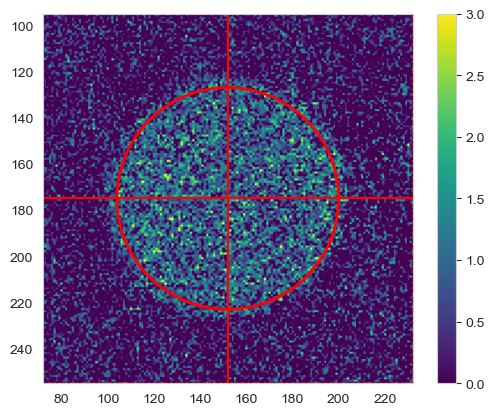

In [7]:
# determine optimal ROI
center = (175, 152)
h = 80
w = 80

image_num = 0

single_prc = la.density_builder([images_raw[image_num]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

circle = plt.Circle((center[1], center[0]), 48, color='r', fill=False, lw = 2)
plt.gca().add_artist(circle)

plt.xlim(center[1] - w, center[1] + w)
plt.ylim(center[0] + h, center[0] - h)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")

plt.grid(False)

plt.colorbar()

plt.show()

In [8]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 180/180 [100%] in 36.8s (4.89/s)     
CPU times: total: 17.1 s
Wall time: 36.8 s


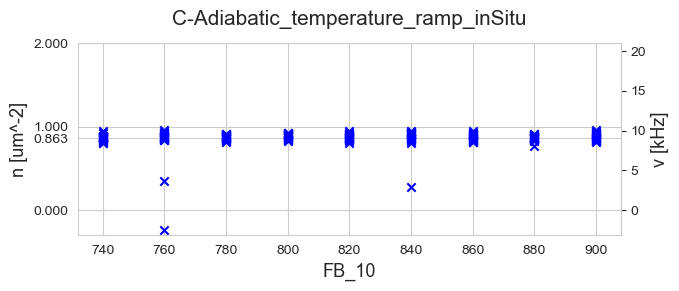

In [10]:
x = []
y = []

def n2v(n):
    return 10.5 * n

def v2n(v):
    return v / 10.5

for i, im in images_prc.iterrows():

    mask = la.circular_mask(np.shape(im["density"]), center, 48)

    bulk = ma.array(im["density"].data, mask = mask)

    x.append(im["FB_10"])
    y.append(ma.mean(bulk))


plt.figure(figsize = (7, 2.5))

plt.scatter(x, y, marker = "x", c = "blue")

plt.title(f"{images_set}", fontsize = 15, pad = 13)
plt.xlabel(f"{variables[1]}", fontsize = 13)
plt.ylabel(f"n [um^-2]", fontsize = 13)

plt.yticks([0, 1, 2, np.mean(y)])

plt.ylim(None, 2)

secax = plt.gca().secondary_yaxis("right", functions = (n2v, v2n))
secax.set_ylabel('v [kHz]', fontsize = 13)

plt.show()

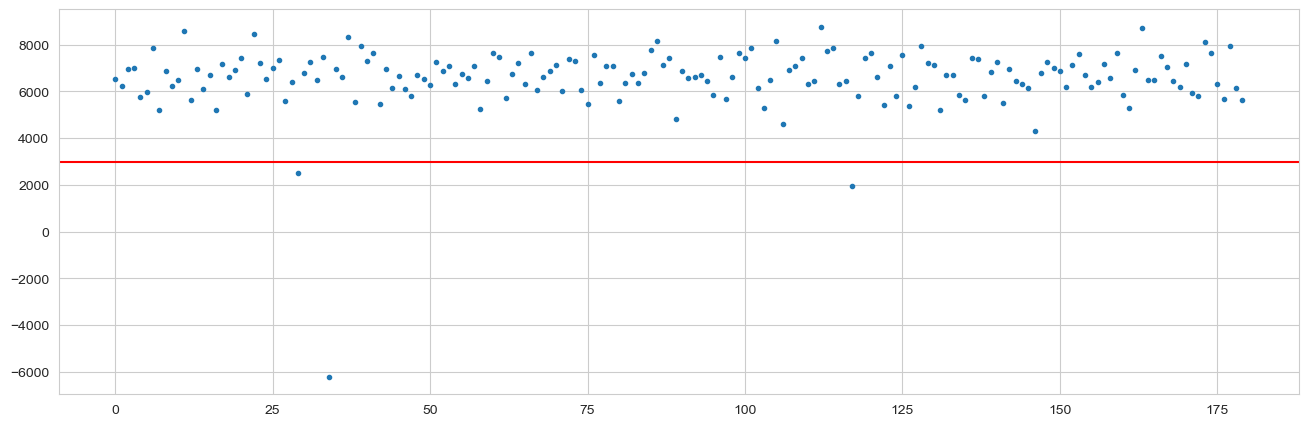

In [13]:
# filter out missed shots
bol = []

for var in var_vals[1]:

    for i, im in images_prc[images_prc[f"{variables[1]}"] == var].iterrows():
        bol.append(np.sum(im["density"]))
        # bol.append(np.sum(im["density"]))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(3000, c = "r")

# plt.ylim(0, None)

plt.show()

In [14]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 3000)

CPU times: total: 31.2 ms
Wall time: 57.2 ms


In [15]:
# plt.imshow(images_fil["density"][2], vmin = 0, vmax = 3, cmap = "viridis")
# plt.show()

In [16]:
# images_fil_selected = images_fil[images_fil["Acc_hold_time"] == 0.001].drop(columns = "Acc_hold_time")

In [17]:
%%time
# group by loop variables and average over iterations
images_grp = la.group(images_fil, variables, "i", info_sorted["Csat"], info_sorted["Img_Illumination_Time"])

MULTI MODE
CPU times: total: 3.94 s
Wall time: 4.09 s


# Visualization

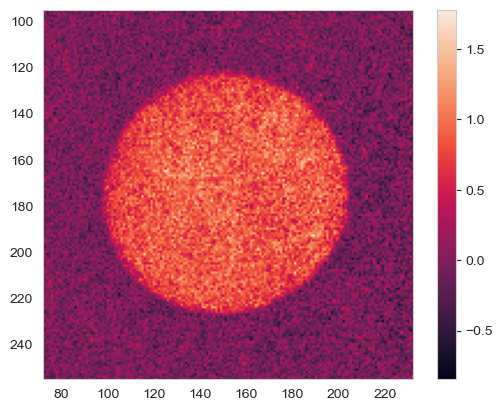

740.0



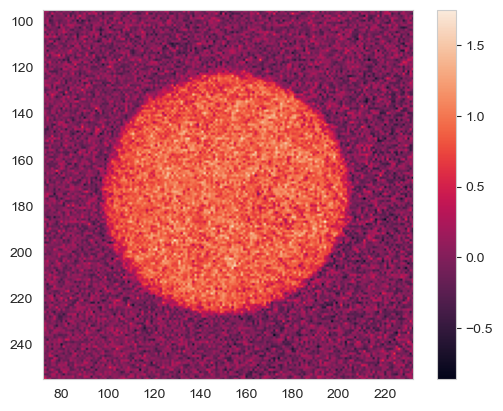

760.0



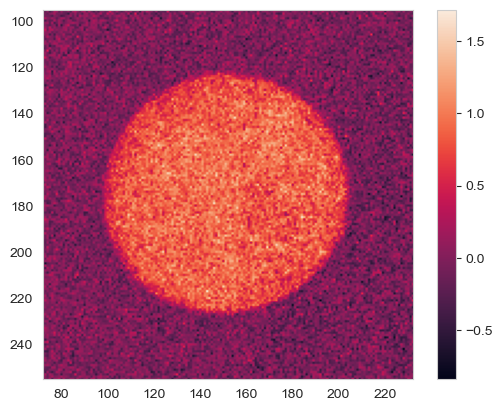

780.0



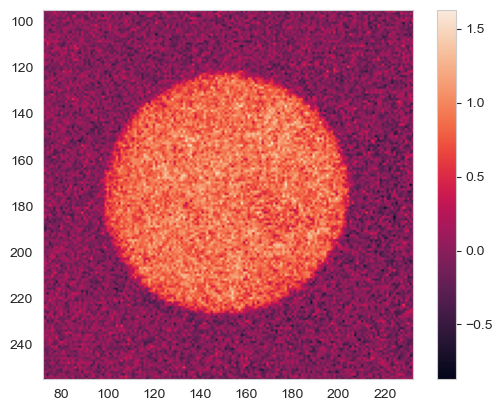

800.0



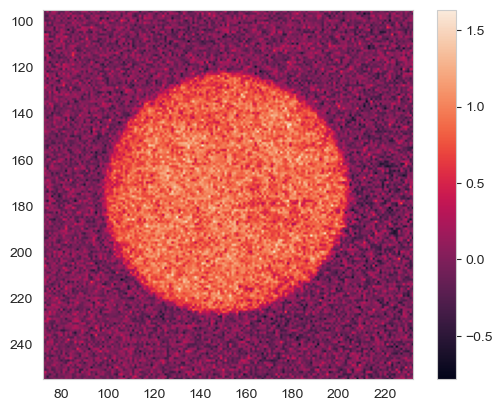

820.0



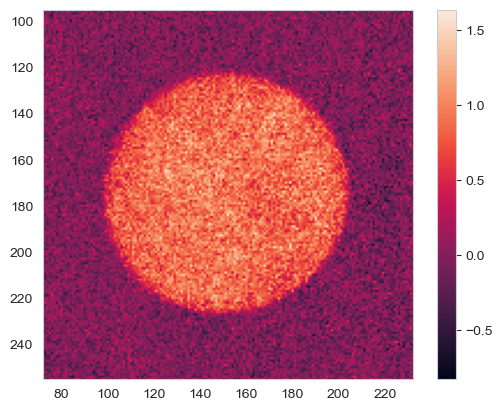

840.0



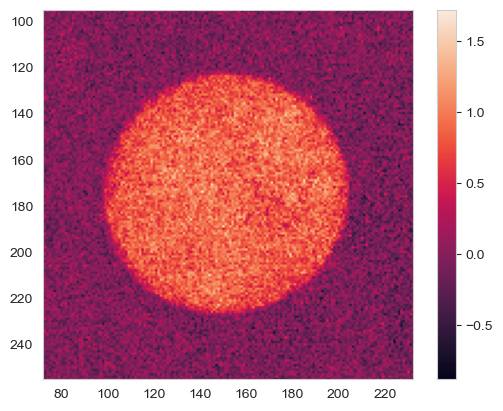

860.0



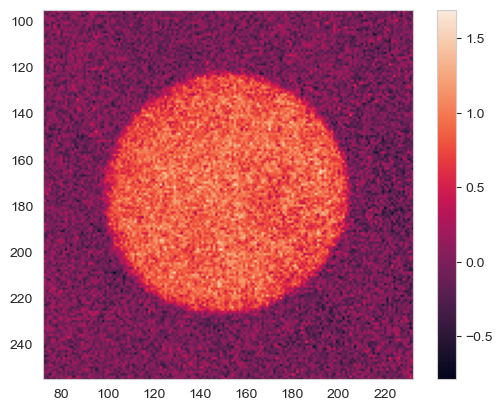

880.0



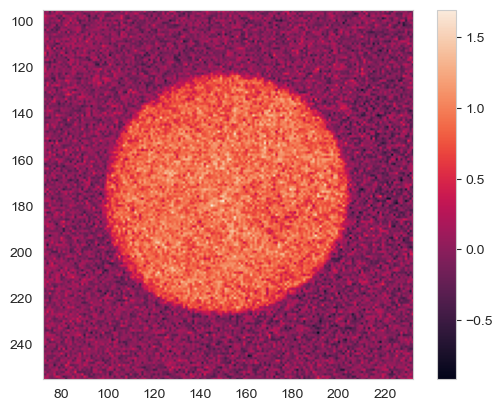

900.0



In [19]:
for i, im in images_grp.iterrows():

    plt.imshow(im["density"])
    plt.colorbar()

    plt.xlim(center[1] - w, center[1] + w)
    plt.ylim(center[0] + h, center[0] - h)

    plt.grid(False)

    plt.show()

    # print(im["i"])
    print(im[f"{variables[1]}"])
    print("")

In [253]:
# length = len(images_grp)//2
#
# for i in range(length):
#
#     # state 1
#     # print("n1")
#     # plt.imshow(images_grp["density"].iloc[i])
#     # plt.xlim(center[1] - w, center[1] + w)
#     # plt.ylim(center[0] - h, center[0] + h)
#     # plt.show()
#
#     # state 2
#     # print("n2")
#     # plt.imshow(images_grp["density"].iloc[length + i])
#     # plt.xlim(center[1] - w, center[1] + w)
#     # plt.ylim(center[0] - h, center[0] + h)
#     # plt.show()
#
#     # difference
#     print(f"n1 - n2, TOF: {images_grp["TOF"].iloc[i]} s")
#     plt.imshow(images_grp["density"].iloc[i] - images_grp["density"].iloc[length + i])
#     plt.xlim(center[1] - w, center[1] + w)
#     plt.ylim(center[0] - h, center[0] + h)
#     plt.show()
#
#     print("")

In [254]:
# heat = images_res.pivot(index="Acc_heat_freq", columns="RF23_Sweep_Rate", values="response")
# heat_run = images_res.pivot(index="Acc_heat_freq", columns="RF23_Sweep_Rate", values="response_run")
#
# plt.plot(heat[70], ".")
# plt.plot(heat_run[70], ".")
#
# plt.ylim(None, 2)
#
# plt.show()

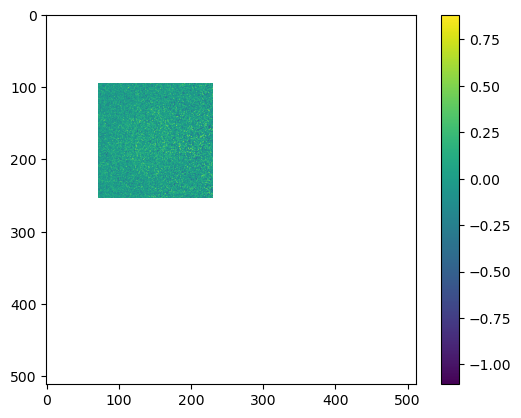

In [255]:
plt.imshow(images_grp["number_var"][0], cmap = "viridis")
plt.colorbar()

# center = (172, 152)
# h = 80
# w = 80

# plt.xlim(center[1] - w, center[1] + w)
# plt.ylim(center[0] + h, center[0] - h)

# plt.xlim(220, 240)
# plt.ylim(180, 150)

plt.show()

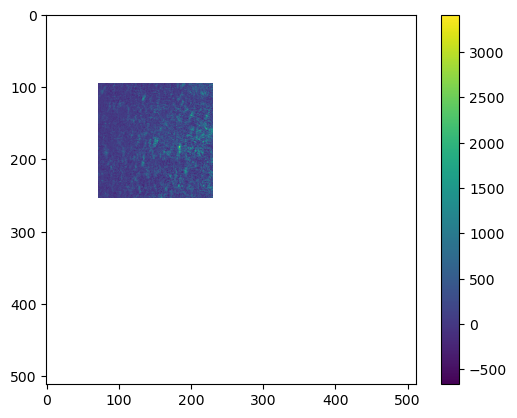

In [256]:
plt.imshow(images_grp["atoms_var"].iloc[0] - images_grp["atoms"].iloc[0], cmap = "viridis")
plt.colorbar()

# center = (172, 152)
# h = 80
# w = 80

# plt.xlim(center[1] - w, center[1] + w)
# plt.ylim(center[0] + h, center[0] - h)

# plt.xlim(220, 240)
# plt.ylim(180, 150)

plt.show()

In [257]:
def circ_ring(r, image_sizes, ring_position):
    '''
    This function creates an image (2D numpy array) of a ring with radius r
    Input:
        r: radius of the circle
        image_sizes: tuple (image_size_x, image_size_y) of image sizes in x/y direction
        ring_position: tuple (pos_x, pos_y), coordinates of the center of the ring (the point (0,0) is in the top left corner)
    Output:
        - ring mask (2D numpy array) with ones/True in the ring and zeros/False outside of the ring
    '''
    image_size_x, image_size_y = image_sizes
    pos_x, pos_y = ring_position

    x = np.arange(0, image_size_x)
    y = np.arange(0, image_size_y)

    r_x, r_y = np.meshgrid(x,y)

    # Mask 1 is the inverse of a circle with radius r
    # Mask 2 is a circle with radius r+1
    mask1 = (r_x-pos_x)**2 + (r_y-pos_y)**2 >= r**2
    mask2 = (r_x-pos_x)**2 + (r_y-pos_y)**2 < (r + 1)**2

    return mask2*mask1 # the overlap of the two masks is a ring

In [258]:
def radial_average(image, averaging_midpoint):
    '''
    This function takes an image (2D numpy array) and calculates its radial average (1D numpy array).
    For plotting one should use the return on the y-axis and radial_axis on the x-axis.
    This function does not control if a radius lies partially outside of the image
    Input:
        image:
        averaging_midpoint: tuple (midpoint_x, midpoint_y), that determines the central point of the radial average (the point (0,0) is in the top left corner)
    Output:
        radial_axis: x-axis to plot the radial_average using e.g. matplotlib.pyplot.plot()
        radial_average:
    '''

    image_sizes = (np.shape(image))[::-1]  # tuple (image_size_x, image_size_y)

    radial_axis = np.arange(0, image_sizes[0]//2)
    radial_sum = np.zeros(image_sizes[0]//2)
    radial_N = np.zeros(image_sizes[0]//2)

    for r in radial_axis:


        radial_sum[r] = np.sum(image * circ_ring(r, image_sizes, averaging_midpoint))  # summed signal at radius r
        radial_N[r] = np.sum(circ_ring(r, image_sizes, averaging_midpoint))   # Number of pixels at radius r

    radial_average = radial_sum/radial_N

    return radial_axis, radial_average

In [259]:
def circ_mask(r, image_sizes, circle_position):
    '''
    This function creates an image (2D numpy array) of a circle with radius r
    Input:
        r: radius of the circle
        image_sizes: tuple (image_size_x, image_size_y) of image_sizes in number of pixels
        circle_position: tuple (pos_x, pos_y)  of the center coordinate of the circle (the point (0,0) is in the top left corner )
    Output:
        - circular mask with ones/True in the circle and zeros/False outside of the circle
    '''
    image_size_x, image_size_y = image_sizes
    pos_x, pos_y = circle_position

    x = np.arange(0, image_size_x)
    y = np.arange(0, image_size_y)

    r_x, r_y = np.meshgrid(x,y)       # r_x, r_y assign to each pixel its x, y coordinate


    mask = (r_x - pos_x)**2 + (r_y - pos_y)**2 <= r**2    # the circle equation is used here

    return mask

In [260]:
number = []
number_var = []

for i in range(len(images_grp)):

    number.append(radial_average(images_grp["density"].iloc[i], (center[1], center[0])))
    number_var.append(radial_average(images_grp["number_var"].iloc[i], (center[1], center[0])))

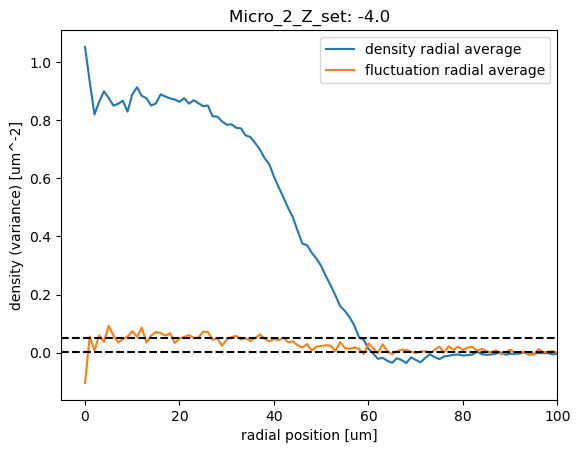

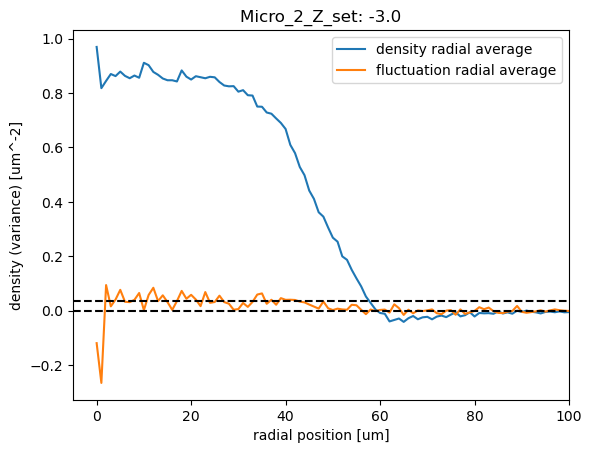

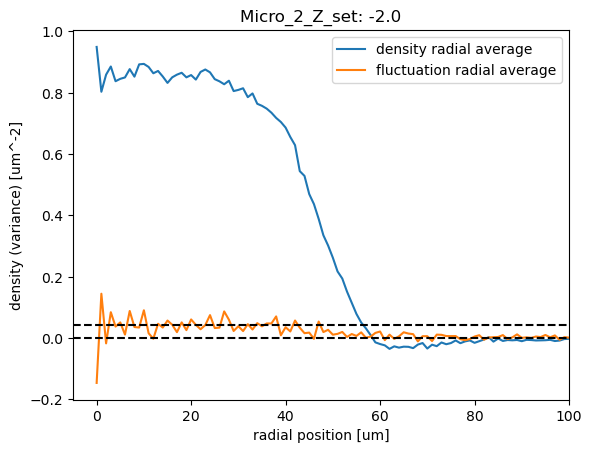

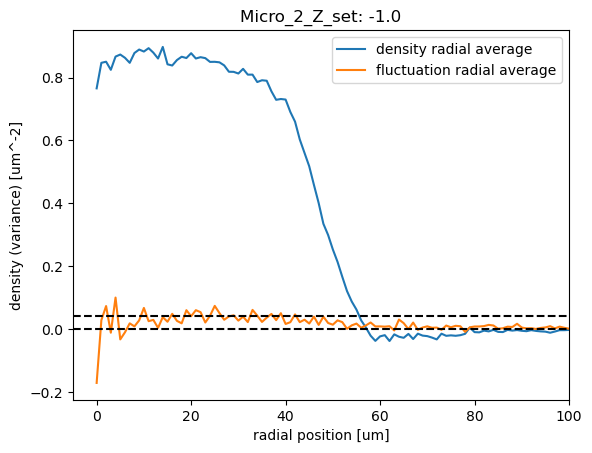

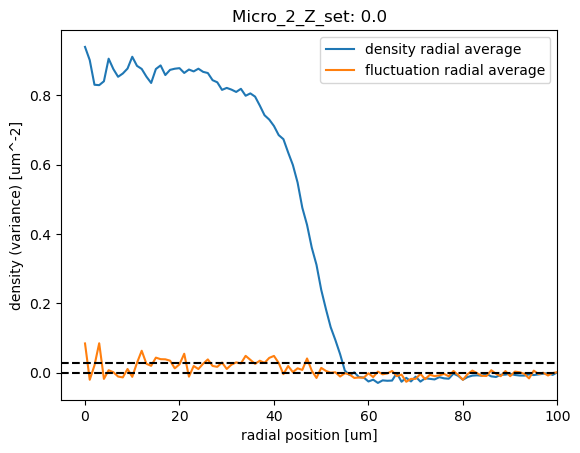

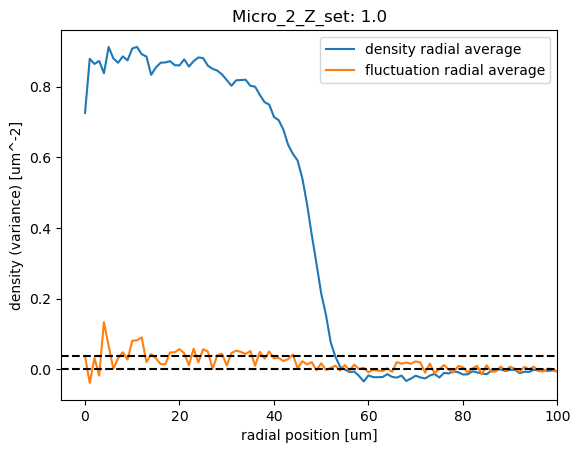

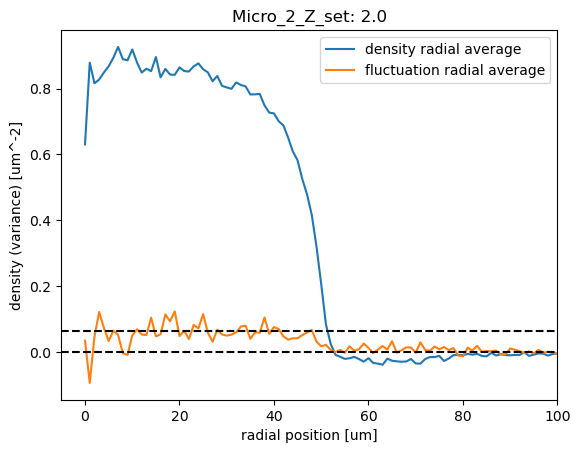

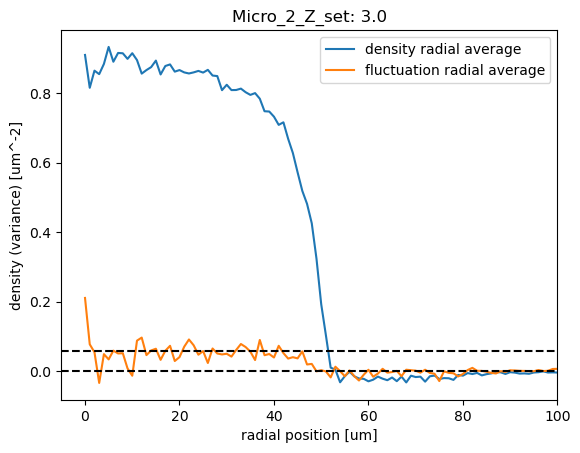

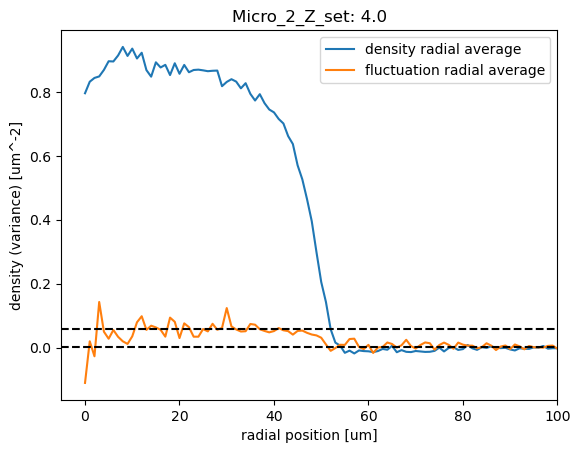

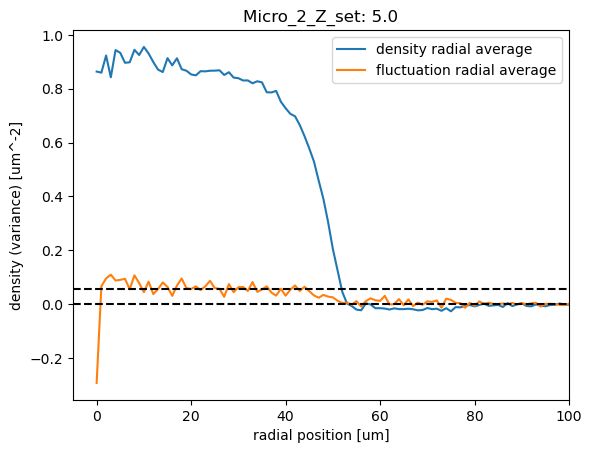

In [261]:
hold = []

for i in range(len(images_grp)):

    plt.plot(number[i][0], number[i][1], label = "density radial average")
    plt.plot(number_var[i][0], number_var[i][1], label = "fluctuation radial average")

    plt.axhline(np.mean(number_var[i][1][20:40]), c = "black", ls = "--")
    plt.axhline(np.mean(number_var[i][1][60:]), c = "black", ls = "--")

    plt.xlim(-5, 100)
    # plt.ylim(-0.1, 0.2)

    plt.title(f"{variables[1]}: {images_grp[f"{variables[1]}"].iloc[i]}")
    plt.xlabel("radial position [um]")
    plt.ylabel("density (variance) [um^-2]")

    plt.legend()

    plt.show()

    hold.append(np.mean(number_var[i][1][20:40]))

    # print(images_grp["Acc_hold_time"].iloc[i])
    # print(np.mean(number_var[i][1][20:40]))
    # print(np.mean(number_var[i][1][60:]))

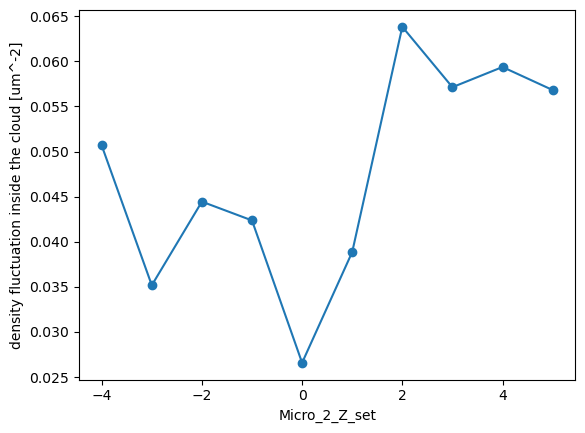

In [262]:
plt.plot(images_grp[f"{variables[1]}"], hold)
plt.scatter(images_grp[f"{variables[1]}"], hold)

plt.xlabel(f"{variables[1]}")
plt.ylabel("density fluctuation inside the cloud [um^-2]")

plt.show()


In [263]:
mean_delta_n = []
mean_n = []

for i in range(len(images_grp)):

    mean_delta_n.append(np.sum(images_grp["number_var"][i] * circ_mask(40, (512,512),(151, 175))) / np.sum(circ_mask(40, (512,512),(151, 175))))
    mean_n.append(np.sum(images_grp["density"][i] * circ_mask(40, (512,512),(151, 175))) / np.sum(circ_mask(40, (512,512),(151, 175))))

mean_delta_n = np.array(mean_delta_n)
mean_n = np.array(mean_n)

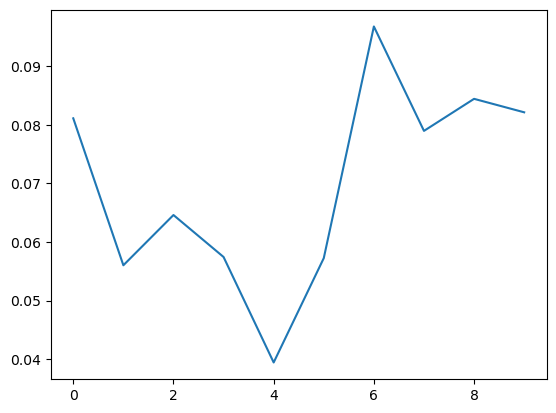

In [264]:
plt.plot(mean_delta_n/mean_n**2)